In [40]:
#importing necessary packages 

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [41]:
#Loading the csv file into dataframes

returns = pd.read_csv('returns.csv', index_col='date')

returns.index = pd.DatetimeIndex(returns.index).to_period('W')

In [42]:
returns.head()

,return
date,
2010-01-04/2010-01-10,0.042071
2010-01-11/2010-01-17,0.009317
2010-01-18/2010-01-24,-0.061538
2010-01-25/2010-01-31,-0.035246
2010-02-01/2010-02-07,0.071368


In [43]:
#Converting the dataframe to a pandas series
returns_series = returns['return']

# Preprocessing

We use TimeSeriesSplit() to do cross-validation while respecting the time order of the data. We make a plot to visualize the train-test split for each cross validation fold.

LEN OF TRAIN_INDEX: 72 LEN OF TEST_INDEX: 69
LEN OF TRAIN_INDEX: 141 LEN OF TEST_INDEX: 69
LEN OF TRAIN_INDEX: 210 LEN OF TEST_INDEX: 69
LEN OF TRAIN_INDEX: 279 LEN OF TEST_INDEX: 69
LEN OF TRAIN_INDEX: 348 LEN OF TEST_INDEX: 69


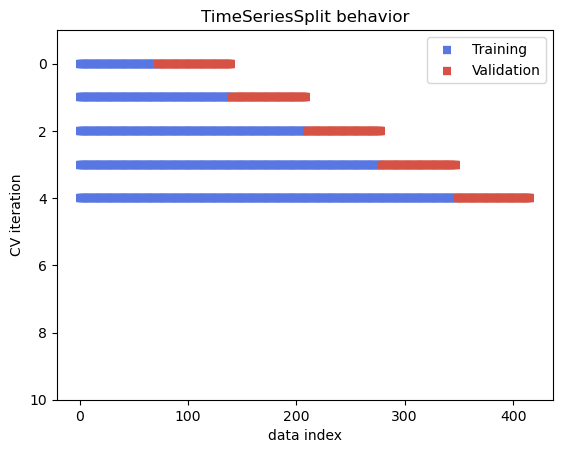

In [44]:
tscv = TimeSeriesSplit()

fig, ax = plt.subplots()
for ii, (train_index, test_index) in enumerate(tscv.split(returns_series)):
    print("LEN OF TRAIN_INDEX:", len(train_index), "LEN OF TEST_INDEX:", len(test_index))
    l1 = ax.scatter(train_index, [ii] * len(train_index), c=[plt.cm.coolwarm(.1)],
                   marker='_', lw=6)
    l2 = ax.scatter(test_index, [ii] * len(test_index), c=[plt.cm.coolwarm(.9)],
                   marker='_', lw=6)
    ax.set(ylim=[10,-1], title='TimeSeriesSplit behavior', xlabel='data index', 
           ylabel='CV iteration')
    ax.legend([l1,l2], ['Training', 'Validation'])

# Modeling

## ARIMA model

In [45]:
scores_list = []

for ii, (train_index, test_index) in enumerate(tscv.split(returns)):
    train, test = list(tscv.split(returns))[ii][0], list(tscv.split(returns))[ii][1]
    model = ARIMA(returns_series[train], order=(0,0,1))
    results = model.fit()
    prediction = results.predict(test[0],test[-1])
    score = MAPE(returns_series[test], prediction)
    scores_list.append((ii, score))

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
scores_list

[(0, 1.1693390360639744),
 (1, 1.2049112011235488),
 (2, 471510079605.75415),
 (3, 363179085015.2484),
 (4, 401793956768.7471)]

In [47]:
order_aic_bic=[]

for p in range(3):
    for q in range(3): 
        model = ARIMA(returns, order=(p,0,q))
        results = model.fit()
        order_aic_bic.append((p,q, results.aic, results.bic))

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [48]:
order_aic_bic

[(0, 0, -1597.9639885920164, -1589.8978161484188),
 (0, 1, -1605.1637752109282, -1593.0645165455317),
 (0, 2, -1603.7799586165463, -1587.6476137293512),
 (1, 0, -1604.4659199586156, -1592.3666612932193),
 (1, 1, -1604.7895044596544, -1588.6571595724592),
 (1, 2, -1604.0001618077185, -1583.8347306987246),
 (2, 0, -1603.1319619306842, -1586.999617043489),
 (2, 1, -1601.2958203892458, -1581.1303892802518),
 (2, 2, -1601.9377346721121, -1577.7392173413193)]

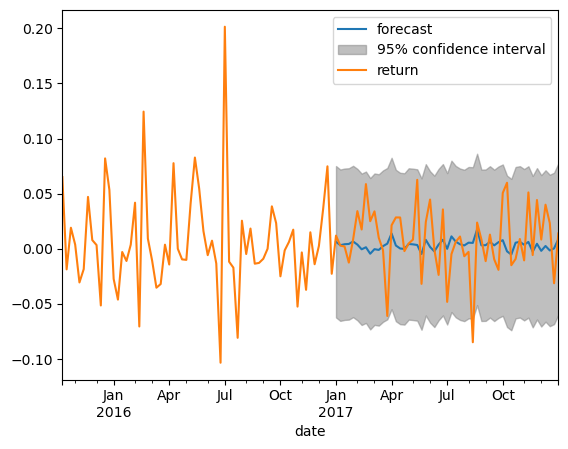

In [49]:
fig, ax = plt.subplots()
res = ARIMA(returns, order=(0,0,1)).fit()
plot_predict(res, start=datetime(2017,1,1), end=datetime(2017,12,31), ax=ax)
returns.iloc[300:].plot(ax=ax)
plt.show()

## Exponential smoothing 

## Facebook prophet